In [18]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
nside=256

In [2]:
binmask_c = hp.read_map('mask_qso_binary_mcs_dust_Av0.2_NSIDE256.fits')
mask_c = hp.read_map('mask_qso_prob_NSIDE256.fits')
mask = rot.rotate_map_pixel(mask_c)
binmask = rot.rotate_map_pixel(binmask_c)

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [3]:
lensmask = hp.read_map('/Users/fabbian/Work/Planck/DR3/COM_Lensing-CIBcomb_2000_R3.00/inputs/mask.fits')
galmask40 = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
galmask = hp.read_map('/Users/fabbian/Work/YxWxSCOSMOS/data/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")


In [8]:
# Prepare raw GAIA data
d=fits.open('gaia_G20.0.fits')

sc = SkyCoord(ra=d[1].data["ra"], dec=d[1].data["dec"], unit='deg', frame='icrs', equinox='J2000.0')
gs = sc.transform_to(frame='galactic')

pix = hp.ang2pix(nside,gs.l.value,gs.b.value,lonlat=True)

m=np.zeros(hp.nside2npix(nside))

for p in pix:
    m[p]+=1

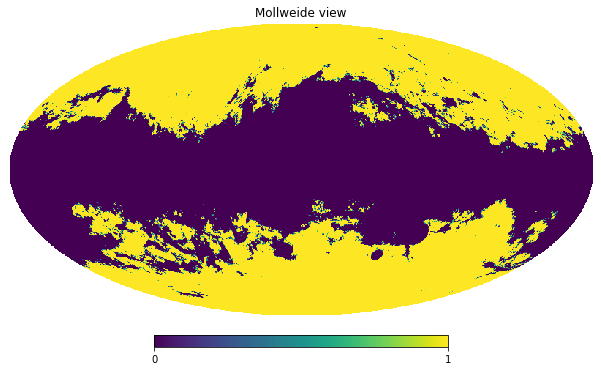

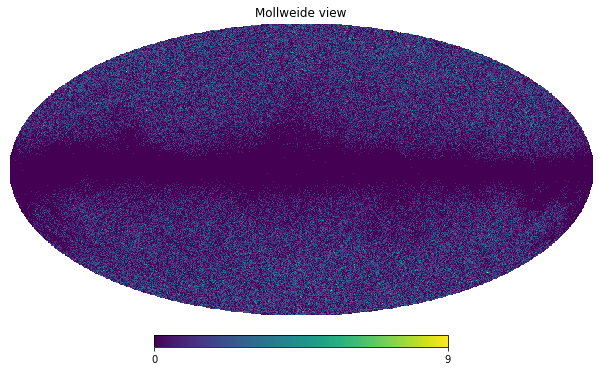

In [10]:
hp.mollview(binmask)
hp.mollview(m)



In [61]:
nbar = np.mean(m[binmask!=0])
c = m/nbar -1
print("nbar",nbar,np.mean(m))

nbar 1.2225455565615475 0.8250452677408854


In [133]:
# compute delta  and k


klm = hp.read_alm('dat_klm.fits')
fl=np.ones(4097)
fl[3*nside-1:]=0.
khr=hp.alm2map(hp.almxfl(klm,fl),nside=2048,pol=False)

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [49]:
khr_cl = hp.anafast(khr,lmax=4096,iter=1,pol=False)

In [141]:
# HEALPix map resolution
nside = 256
binmask[binmask!=0]=1
apomask = nmt.mask_apodization(binmask,0.5, apotype="C2")
apomask_gal = nmt.mask_apodization(hp.ud_grade(galmask,nside_out=256),1, apotype="C2")
delta_b=50
b = nmt.NmtBin.from_nside_linear(nside, delta_b,is_Dell=False)
lb = b.get_effective_ells()

# here below I define different Cl coupling matrix with different masks.
klr = hp.ud_grade(khr,nside_out=nside)
f0 = nmt.NmtField(apomask, [klr])
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b)

def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [142]:
f1 = nmt.NmtField(apomask, [c])
clkg = compute_master(f0, f1, w)[0]
clgg = compute_master(f1, f1, w)[0]
clkk = compute_master(f0, f0, w)[0]

snr 15.828086957864562 18.95778152905551


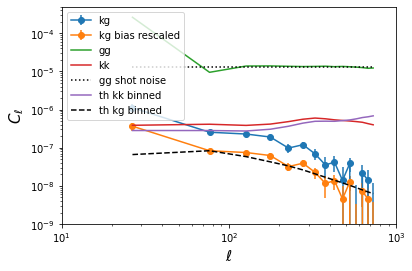

In [166]:
#delta_b=100
cl_gg_th_binned = w.decouple_cell(w.couple_cell([cls['W1xW1']]))[0]
cl_kg_th_binned = w.decouple_cell(w.couple_cell([cls['PxW1']*p2k]))[0]
cl_kk_th_binned = w.decouple_cell(w.couple_cell([hp.alm2cl(klm)]))[0]

dkg = np.sqrt(clkk*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(binmask))
dkg_th = np.sqrt(cl_kk_th_binned*clgg + clkg**2)/np.sqrt((2*lb+1)*delta_b*np.mean(binmask))
pl.errorbar(lb,clkg,dkg,label='kg',marker='o')
rescale = cl_kg_th_binned[1]/clkg[1]
pl.errorbar(lb,clkg*rescale,dkg*rescale,label='kg bias rescaled',marker='o')
#pl.errorbar(lb,clkg,dkg_th,label='')
pl.errorbar(lb,clgg,label='gg')
#pl.errorbar(lb,clgg*rescale**2,label='gg rescale')
pl.errorbar(lb,clkk,label='kk')
pl.errorbar(lb,lb*hp.nside2resol(nside)**2*1/nbar/lb,color='black',label='gg shot noise',ls=':')
clklr=hp.anafast(klr*apomask_gal)/np.mean(apomask_gal)
#pl.errorbar(np.arange(len(clklr)),clklr,label='kk low res',zorder=0)
pl.errorbar(lb,cl_kk_th_binned,label='th kk binned')
pl.errorbar(lb,cl_kg_th_binned,label='th kg binned',color='black',ls='--')
#pl.errorbar(lb,cl_gg_th_binned,label='th gg binned',color='black',ls='-.')
#pl.loglog(hp.alm2cl(klm))
#pl.loglog(khr_cl)
pl.xscale("log")
pl.yscale("log")
pl.ylim(1e-09,5e-04)
pl.xlim(10,1000)
pl.legend(loc='best')
pl.xlabel('$\ell$',size=15)
pl.ylabel('$C_\ell$',size=15)
print("snr",np.sqrt(np.cumsum(clkg[1:]**2/dkg[1:]**2)[-1]),np.sqrt(np.cumsum(clkg**2/dkg_th**2)[-1]))

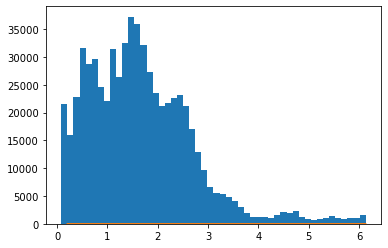

In [114]:
dndz= pl.hist(d[1].data['redshift_qsoc'],bins=50)
dndz=[np.diff(dndz[1])+dndz[1][:-1],dndz[0]]
# read dn/dz and normalize it
dndz[1]/=np.trapz(dndz[1],dndz[0])
pl.plot(dndz[0],dndz[1])

import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
pars = camb.CAMBparams()
lmax=1000
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=4)
##set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = True

##NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both


#density only is the default
pars.SourceTerms.limber_windows = True
pars.SourceTerms.limber_phi_lmin = 300
pars.SourceTerms.counts_lensing = True
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = True #weird problems at times
pars.SourceTerms.counts_radial   = True # negligible at l<10
pars.SourceTerms.counts_timedelay = True # negligible
pars.SourceTerms.counts_ISW = True #negligible
pars.SourceTerms.counts_velocity = True #negligible
pars.SourceTerms.counts_potential = True #negligible

##Set up W(z) window functions, later labelled W1 from Gaia dN/dz function.
W=np.array(dndz[1])
z=np.array(dndz[0])
pars.SourceWindows = [SplinedSourceWindow(bias_z=2.35, z=z, W=W,source_type='counts')]

results = camb.get_results(pars)

# In the returned dictionary P is the lensing potential and not deflection as in camb doc if raw_cl=True. 
# potentially related to CAMB version and fixed in later ones?
cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')
cls = results.get_source_cls_dict(raw_cl=True) 



/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


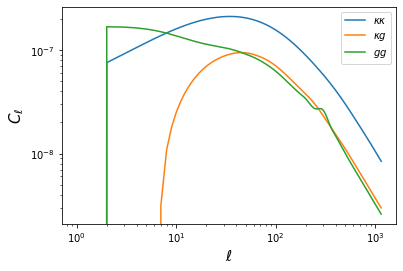

/Users/fabbian/Software/anaconda2/envs/toast/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


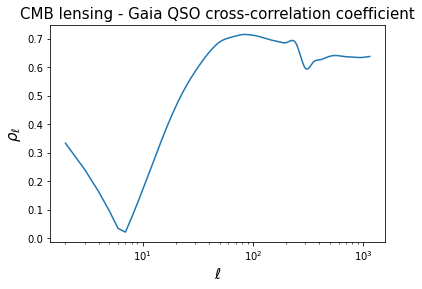

In [115]:
# plots power spectra
ls = np.arange(len(cls['PxP']))
p2d=np.sqrt(ls*(ls+1))
d2p=1/p2d
d2p[0:2]=0.0
d2k=p2d/2
p2k=(p2d**2/2)

pl.loglog(ls,cls['PxP']*p2k**2,label='$\kappa\kappa$')
pl.loglog(ls,cls['PxW1']*p2k,label='$\kappa g$') # should give kappaX for cross correlation
pl.loglog(ls,cls['W1xW1'],label='$gg$') 
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.legend()
pl.show()

rho = cls['PxW1']*p2k/np.sqrt(np.abs(cls['PxP']*(p2k**2)*cls['W1xW1']))
pl.semilogx(ls,np.abs(rho))
pl.xlabel("$\ell$",size=15)
pl.ylabel("$\\rho_\ell$",size=15)
pl.title("CMB lensing - Gaia QSO cross-correlation coefficient",size=15)
pl.show()

4.383368280395689e-05


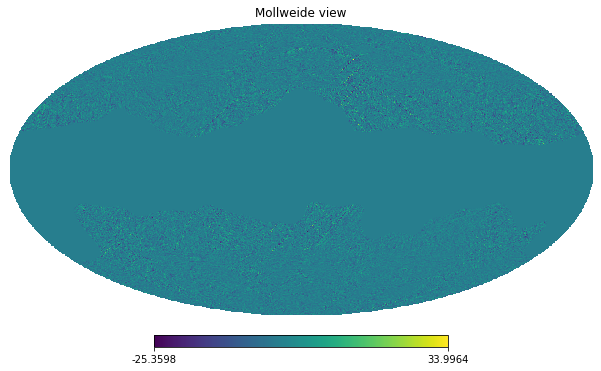

In [127]:
hp.mollview(klr*apomask_gal)
print(np.mean(klr[apomask_gal!=0]))

In [151]:
rescale**2

0.10716268648137707